In [5]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os

In [6]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [12]:
def train_transform(dataset):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
    mean,std=get_mean_std(train_loader)
    train_transforms = transforms.Compose([
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,drop_last=False,num_workers=0)
    return train_loader,train_dataset

In [16]:
train_dataset='../Datasets/dataset_2_classes/test/'
train_loader,training_dataset=train_transform(train_dataset)

In [14]:
def show_transformed_images(dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=12,shuffle=True)
    batch=next(iter(loader))
    images, labels=batch
    
    grid=torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


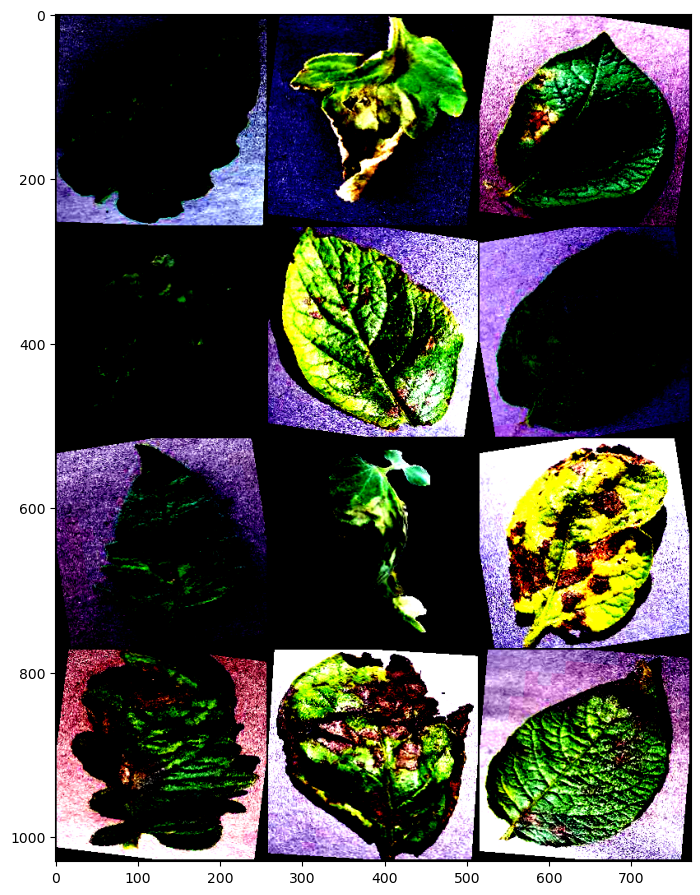

In [17]:
show_transformed_images(training_dataset)

In [18]:
validate_dataset='../Datasets/dataset_2_classes/validate/'
validate_loader,validating_dataset=train_transform(validate_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])


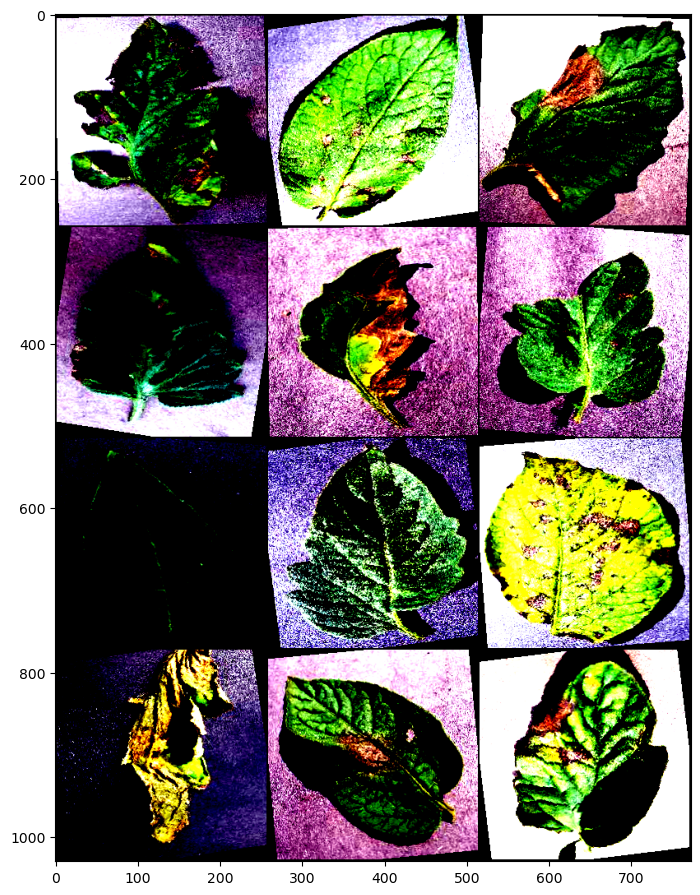

In [19]:
show_transformed_images(validating_dataset)

In [22]:
test_dataset='../Datasets/dataset_2_classes/test/'
test_loader,testing_dataset=train_transform(test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])


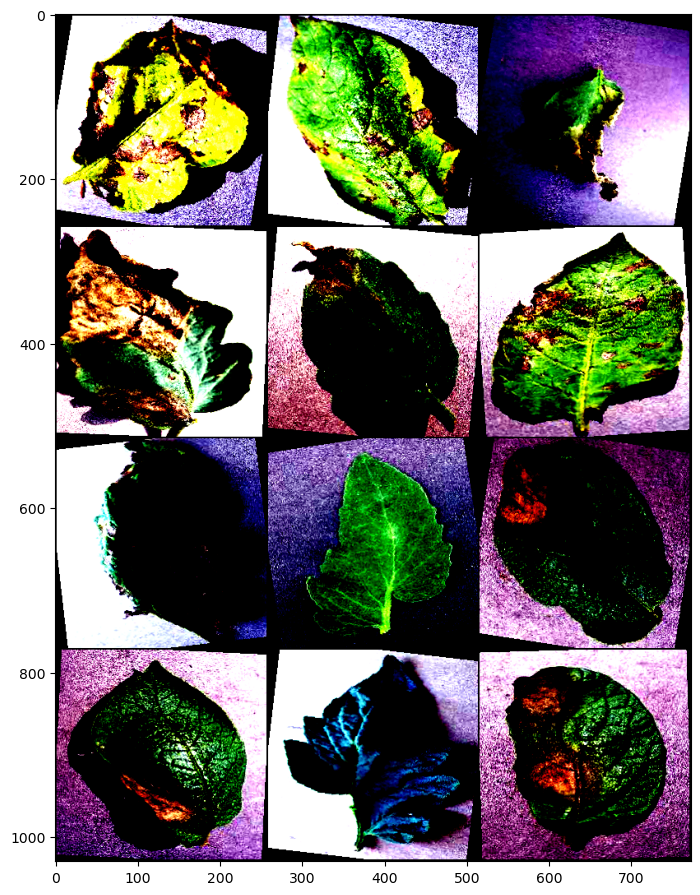

In [23]:
show_transformed_images(testing_dataset)

In [24]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [25]:
resnet18_Model = models.resnet18(pretrained=False, num_classes=2)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
count_parameters(resnet18_Model)

11177538

In [28]:
device=set_device()
resnet18_Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
print("Device: {}".format(device))

Device: mps


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_Model.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
n_epochs = 100
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
validation_accuracy = 0

In [33]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    resnet18_Model.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=resnet18_Model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    resnet18_Model.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in validate_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=resnet18_Model(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(validate_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))
    
        

Epoch: 1 
Training Data: Epoch Loss: 0.503, Epoch Accuracy: 79.688, Validation Loss: 0.598
Epoch: 2 
Training Data: Epoch Loss: 0.424, Epoch Accuracy: 81.152, Validation Loss: 0.502
Epoch: 3 
Training Data: Epoch Loss: 0.371, Epoch Accuracy: 81.152, Validation Loss: 0.427
Epoch: 4 
Training Data: Epoch Loss: 0.290, Epoch Accuracy: 85.352, Validation Loss: 0.327
Epoch: 5 
Training Data: Epoch Loss: 0.217, Epoch Accuracy: 94.629, Validation Loss: 0.269
Epoch: 6 
Training Data: Epoch Loss: 0.166, Epoch Accuracy: 95.898, Validation Loss: 0.232
Epoch: 7 
Training Data: Epoch Loss: 0.139, Epoch Accuracy: 96.094, Validation Loss: 0.209
Epoch: 8 
Training Data: Epoch Loss: 0.117, Epoch Accuracy: 96.484, Validation Loss: 0.200
Epoch: 9 
Training Data: Epoch Loss: 0.107, Epoch Accuracy: 96.973, Validation Loss: 0.194
Epoch: 10 
Training Data: Epoch Loss: 0.103, Epoch Accuracy: 96.875, Validation Loss: 0.185
Epoch: 11 
Training Data: Epoch Loss: 0.087, Epoch Accuracy: 97.363, Validation Loss: 0.1

Training Data: Epoch Loss: 0.030, Epoch Accuracy: 98.828, Validation Loss: 0.115
Epoch: 92 
Training Data: Epoch Loss: 0.021, Epoch Accuracy: 99.512, Validation Loss: 0.112
Epoch: 93 
Training Data: Epoch Loss: 0.022, Epoch Accuracy: 99.512, Validation Loss: 0.108
Epoch: 94 
Training Data: Epoch Loss: 0.019, Epoch Accuracy: 99.414, Validation Loss: 0.106
Epoch: 95 
Training Data: Epoch Loss: 0.019, Epoch Accuracy: 99.512, Validation Loss: 0.107
Epoch: 96 
Training Data: Epoch Loss: 0.025, Epoch Accuracy: 99.219, Validation Loss: 0.095
Epoch: 97 
Training Data: Epoch Loss: 0.039, Epoch Accuracy: 98.340, Validation Loss: 0.091
Epoch: 98 
Training Data: Epoch Loss: 0.027, Epoch Accuracy: 98.828, Validation Loss: 0.087
Epoch: 99 
Training Data: Epoch Loss: 0.030, Epoch Accuracy: 99.121, Validation Loss: 0.106
Epoch: 100 
Training Data: Epoch Loss: 0.020, Epoch Accuracy: 99.414, Validation Loss: 0.135


In [36]:
print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(resnet18_Model.state_dict(), "2-Class-Resnet18-"+str(epoch_count)+"-epoch.pt")

---Training finished in 2892.120115041733 seconds---


In [59]:

from torchmetrics import F1Score,ConfusionMatrix

In [64]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [65]:
test_acc = evaluate_model(resnet18_Model,test_loader)

Testing Data: Epoch Accuracy: 100.000


In [42]:
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("Accuracies_Resnet18_2classes"+str(epoch_count)+".csv")
df2.to_csv("Loss_Resnet18_2classes"+str(epoch_count)+".csv")

In [44]:
print(val_loss/len(validate_loader))

0.0064397503488830155


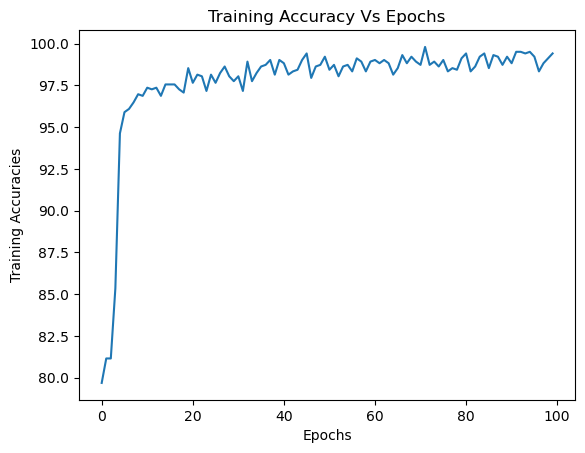

In [45]:
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

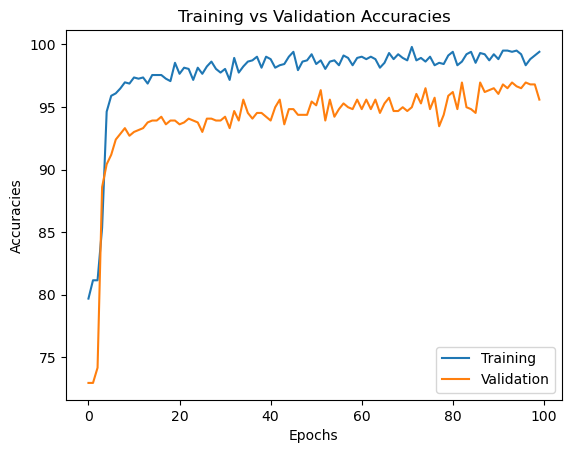

In [46]:
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

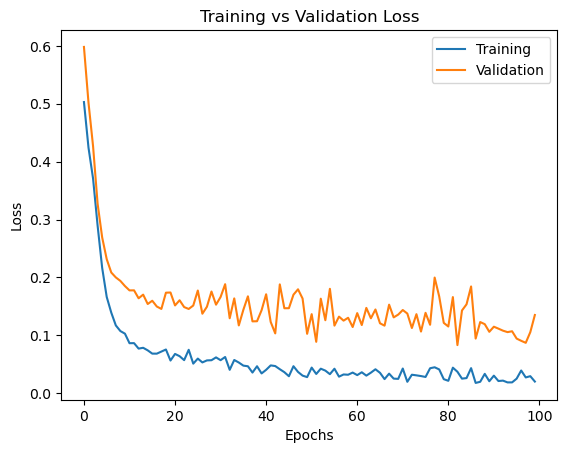

In [47]:
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [52]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet18_Model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

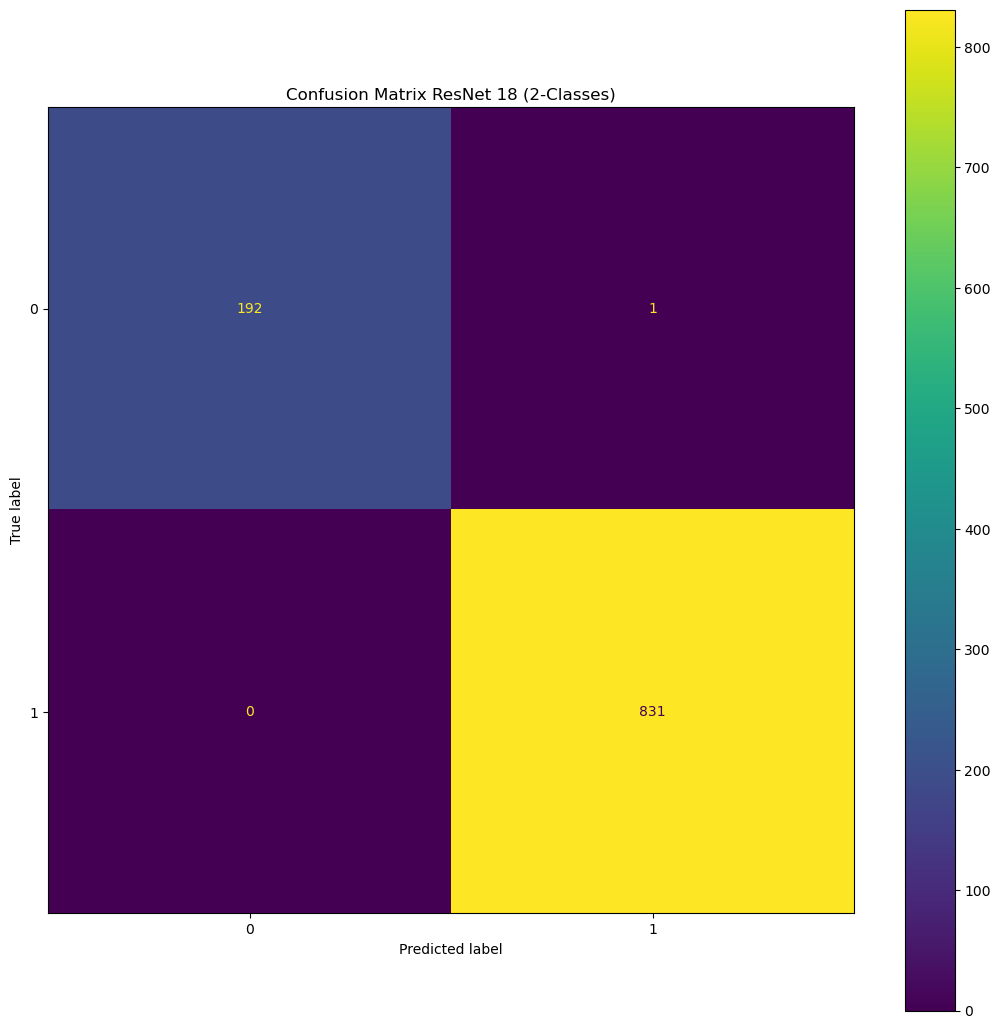

In [53]:
classes = (0,1)
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix ResNet 18 (2-Classes)")
disp.plot(ax=ax)
plt.show()

In [57]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:1.00
Precision Micro:1.00
Recall Macro:1.00
Recall Micro:1.00
F1-Score Macro:1.00
F1-Score Micro:1.00


Test Accuracy of the model on the 1024 test images: 99.70703125 %


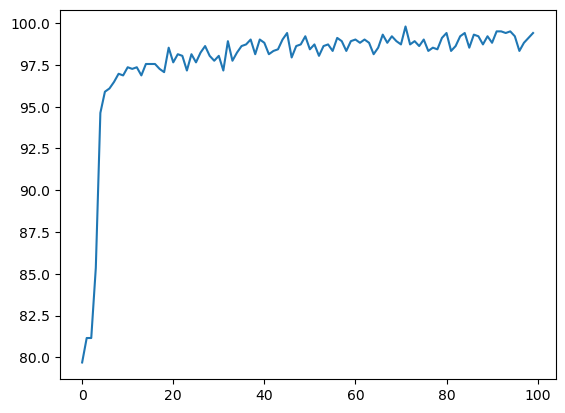

In [66]:
resnet18_Model.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)